# ResNet50 - Transfer Learning

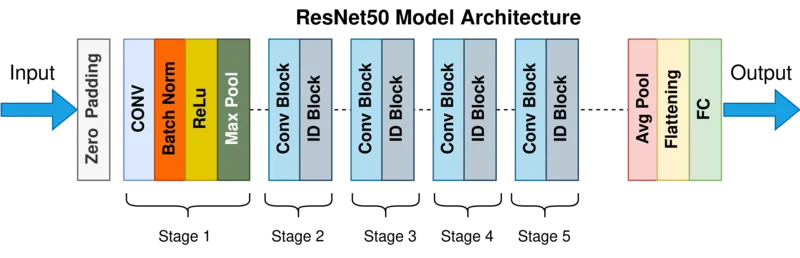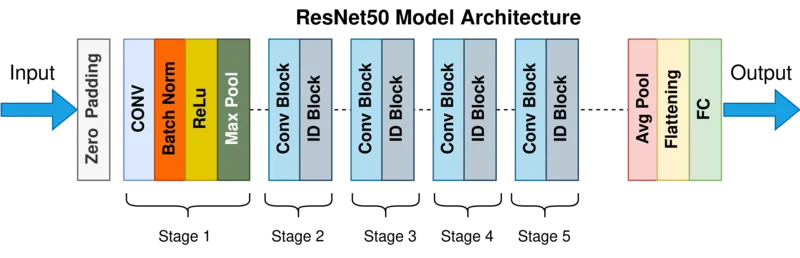

In [5]:
print('Hello Python')

import os
import cv2
import imghdr
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# Model building

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, BatchNormalization, MaxPool2D, Activation, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.regularizers import L2
from tensorflow.keras.initializers import HeNormal

from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

Hello Python
Num GPUs Available:  1


In [6]:
# Training and Testing data set path
train_path = r"/kaggle/input/fer2013/train"
test_path = r"/kaggle/input/fer2013/test"

# Setting up parameters
num_classes = 7
image_width, image_height = 224, 224
batch_size = 32

# Image Augmentation to generate image by applying different augmentation techniques
train_data_generator = ImageDataGenerator(
    rescale=1./255, # normalize image chennal 0-255 into 0-1
    rotation_range=40, # giving rotation to image by giving degree
    width_shift_range=0.2, # range for horizontal width shift(as fraction of total width)
    height_shift_range=0.2, # range for vertical width shift(as fraction of total height)
    fill_mode='nearest', # Strategy to fill newly created pixels, which can appear after rotation or width/height shift 
    horizontal_flip=True, # randomly flip inputs horizontaly
    shear_range=0.2, # shearing intensity (shear angle in counter clockwise direction)
    zoom_range=0.2, # range for random zoom
    validation_split=0.2, # set validation split, 20% of data used for validation
)

test_data_generator = ImageDataGenerator(rescale=1.0/255)

In [7]:
# Automaticly receive image from directory
train_generator = train_data_generator.flow_from_directory(
    directory=train_path,
    target_size=(image_width, image_height),
    color_mode='rgb',
    class_mode='categorical',
    subset='training',
    batch_size=batch_size
)

validation_generator = train_data_generator.flow_from_directory(
    directory=train_path,
    target_size=(image_width, image_height),
    color_mode='rgb',
    class_mode='categorical',
    subset='validation',
    batch_size=batch_size
)

test_generator = test_data_generator.flow_from_directory(
    directory=test_path,
    target_size=(image_width, image_height),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# Class weight for Imbalanced dataset

In [8]:
# classes
print("Training class labels", train_generator.class_indices)
print("Testing class labels", test_generator.class_indices)

Training class labels {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Testing class labels {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [9]:
from sklearn.utils.class_weight import compute_class_weight

In [10]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# calculate class weight handle Imbalanced training dataset
# 'balance' mode automatically adjust weight inversly proportional class frequencies
class_weight = compute_class_weight(class_weight='balanced', # strategy to balance classes
                     classes=np.unique(classes), # unique class labels
                     y=classes) # class labels for each instance in training dataset

# create a dictionary mapping class indices to their calculated weights
class_weight_dict = dict(enumerate(class_weight))

print(class_weight_dict)

{0: 1.0266404434114071, 1: 9.401555464592715, 2: 1.0009587727708533, 3: 0.5684585684585685, 4: 0.826068191627104, 5: 0.8491570541259982, 6: 1.2933160650937552}


In [11]:
# load resnet50v2 base model excluding top fully connected layers
resnet = ResNet50V2(
    input_shape=(image_width, image_height, 3),
    include_top=False,
    weights='imagenet'
)

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [12]:
# resnet.summary()

In [13]:
print(len(resnet.layers))

# Except last 50 layers, all layer makes non trainable
for layer in resnet.layers[:-50]:
    layer.trainable=False


190


In [14]:
# customizing resnet for our usecase
# Flattening the layer and adding custom Dense layers
x = BatchNormalization()(resnet.output)
x = Flatten()(x)

# adding fully connected layer
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

# output layer
output = Dense(units=num_classes, activation='softmax')(x)

In [15]:
# create model

model = Model(inputs=resnet.input, outputs=output)

In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 29,996,295 (114.43 MB)

 Trainable params: 22,779,527 (86.90 MB)

 Non-trainable params: 7,216,768 (27.53 MB)

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
cnn_path = r"/kaggle/working/"
file_name = 'ResNet50_Emotion.keras'
chk_path = os.path.join(cnn_path, file_name)
print(chk_path)

/kaggle/working/ResNet50_Emotion.keras


In [19]:
# callback to save model checkpoints
checkpoint = ModelCheckpoint(filepath=chk_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# callback to stop training if val loss not decrease
earlystopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True, mode='min')

# callback to reduce learning rate
reduceLRplt = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.00005)

# callback to save training log into csv file
csvlogger = CSVLogger(filename=os.path.join(cnn_path, 'ResNet50_Emotion.log'))

# all callbacks
callbacks = [checkpoint, earlystopping, reduceLRplt, csvlogger]

In [20]:
# steps
print(train_generator.samples)
train_steps_per_epoch = train_generator.samples // train_generator.batch_size +1
validation_steps_per_epoch = validation_generator.samples // train_generator.batch_size
test_steps_epoch = test_generator.samples // test_generator.batch_size
print(train_steps_per_epoch)
print(validation_steps_per_epoch)
print(test_steps_epoch)

22968
718
179
224


In [21]:
history = model.fit(
                  train_generator,
                  epochs=50,
                  validation_data=validation_generator,
                  class_weight=class_weight_dict,
                  callbacks = callbacks
                )

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.2217 - loss: 2.1396
Epoch 1: val_loss improved from inf to 2.38125, saving model to /kaggle/working/ResNet50_Emotion.keras
718/718 ━━━━━━━━━━━━━━━━━━━━ 394s 513ms/step - accuracy: 0.2217 - loss: 2.1394 - val_accuracy: 0.2867 - val_loss: 2.3812 - learning_rate: 0.0010
Epoch 2/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.2941 - loss: 1.8508
Epoch 2: val_loss improved from 2.38125 to 1.67337, saving model to /kaggle/working/ResNet50_Emotion.keras
718/718 ━━━━━━━━━━━━━━━━━━━━ 293s 405ms/step - accuracy: 0.2941 - loss: 1.8507 - val_accuracy: 0.3757 - val_loss: 1.6734 - learning_rate: 0.0010
Epoch 3/50
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.3582 - loss: 1.7110
Epoch 3: val_loss improved from 1.67337 to 1.64257, saving model to /kaggle/working/ResNet50_Emotion.keras
718/718 ━━━━━━━━━━━━━━━━━━━━ 294s 406ms/step - accuracy: 0.3582 - loss: 1.7110 - val_accuracy: 0.3888 - val_loss: 1.6426 - learning_rate: 0.

In [22]:
def plotting_training_history(history):
    train_acc = history['accuracy']
    train_loss = history['loss']
    val_acc = history['val_accuracy']
    val_loss = history['val_loss']

    epoch_range = range(len(train_acc))

    plt.figure(figsize=(20, 5))

    # plot training and validation accuracy
    plt.subplot(1,2,1)
    plt.plot(epoch_range, train_acc, label='train_accuracy')
    plt.plot(epoch_range, val_acc, label='val_accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy Plot')

    # plot training and validation loss
    plt.subplot(1,2,2)
    plt.plot(epoch_range, train_loss, label='train_loss')
    plt.plot(epoch_range, val_loss, label='val_loss')
    plt.legend()
    plt.title('Training and Validation Loss Plot')

    plt.show()

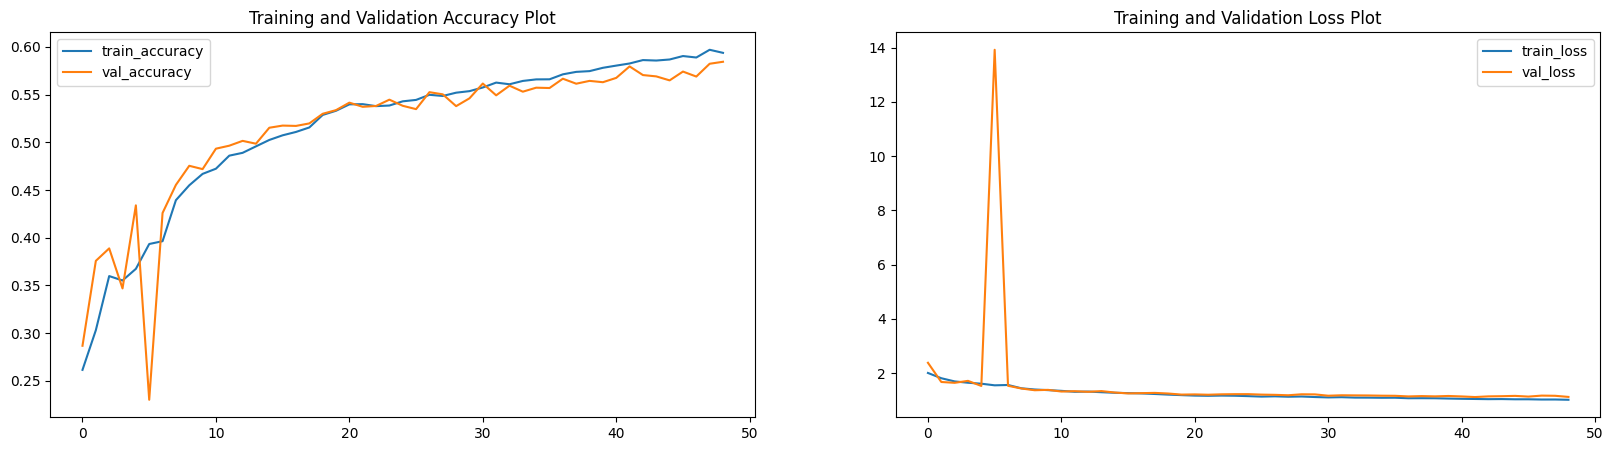

In [24]:
plotting_training_history(history.history)

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

225/225 ━━━━━━━━━━━━━━━━━━━━ 30s 121ms/step


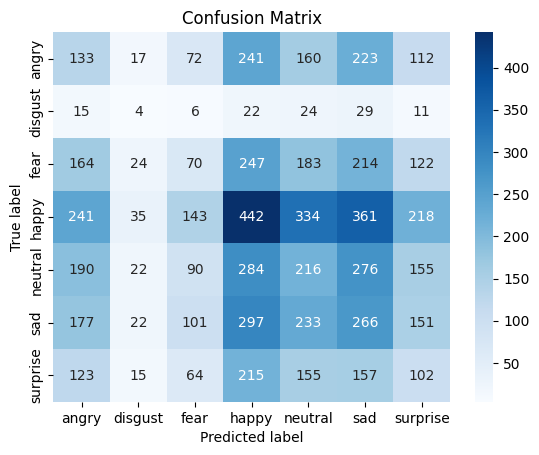

In [26]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size).astype('int')), axis=1)
class_labels = list(test_generator.class_indices.keys())

# generate confusion matrix
c_matrix = confusion_matrix(true_classes, predicted_classes)

# plotting with seaborn
sns.heatmap(c_matrix, annot=True, xticklabels=class_labels, yticklabels=class_labels, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [27]:
# generating classification_report
# Precision is defined as the ratio of correctly classified positive samples (True Positive) to a total number of classified positive samples
# The recall measures the model's ability to detect positive samples.
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

              precision    recall  f1-score   support

       angry       0.13      0.14      0.13       958
     disgust       0.03      0.04      0.03       111
        fear       0.13      0.07      0.09      1024
       happy       0.25      0.25      0.25      1774
     neutral       0.17      0.18      0.17      1233
         sad       0.17      0.21      0.19      1247
    surprise       0.12      0.12      0.12       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



# ROC AUC Plot for each Class

In [48]:
y_encoded = pd.get_dummies(true_classes).astype(int).values
pred_encoded = pd.get_dummies(predicted_classes).astype(int).values

False_Positive_Rate, True_Positive_Rate = dict(), dict()
roc_auc = dict()

In [49]:
for i in range(num_classes):
    False_Positive_Rate[i], True_Positive_Rate[i], _ = roc_curve(y_encoded[:, i], pred_encoded[:, i])
    roc_auc[i] = auc(False_Positive_Rate[i], True_Positive_Rate[i])

print(roc_auc)

{0: 0.4962643234498453, 1: 0.5084665817650111, 2: 0.4955056543508287, 3: 0.5037408091379971, 4: 0.4960016698077879, 5: 0.5004344265387157, 6: 0.50079203967422}


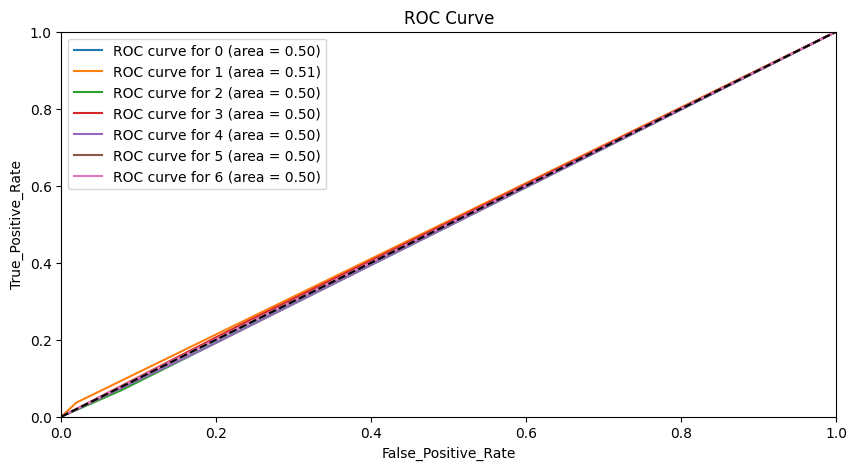

In [53]:
plt.figure(figsize=(10,5))
classes = list(train_generator.class_indices.values())
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
for i, color in enumerate(colors):
    plt.plot(False_Positive_Rate[i], True_Positive_Rate[i], color=color, label=f"ROC curve for {classes[i]} (area = {roc_auc[i]:0.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False_Positive_Rate")
plt.ylabel("True_Positive_Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [44]:
model.save("Resnet_model_version_2.keras")

(7178,)

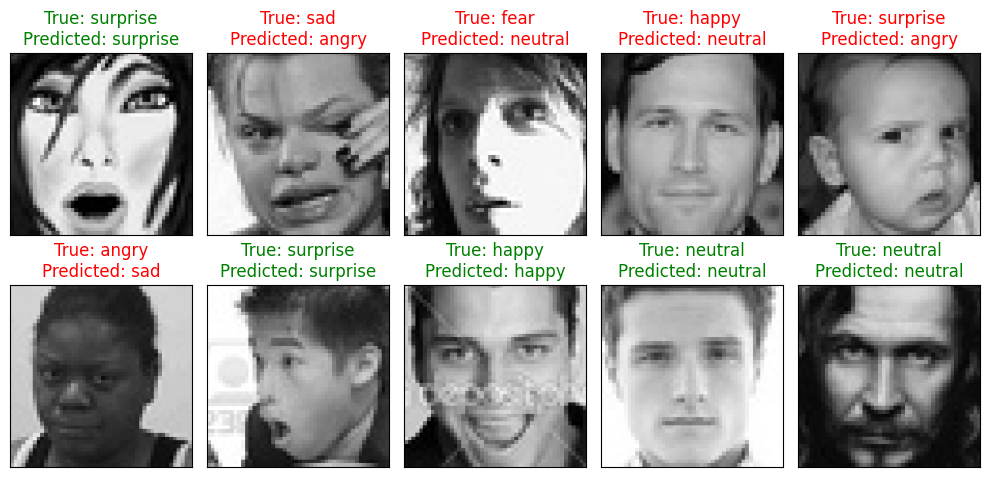

In [60]:
# Emotion classes for the dataset
emotion = class_labels

batch_size = test_generator.batch_size
# selection of random batch
random_batch = np.random.randint(0, len(test_generator)-1)
# selection of random image indices from batch_size
random_img_indices = np.random.randint(0, batch_size, 10)

# setting up plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    random_image = test_generator[random_batch][0][random_img_indices[i]]
    random_image_label = np.argmax(test_generator[random_batch][1][random_img_indices[i]])

    # making prediction over random fatched image
    model_prediction = np.argmax(model.predict(tf.expand_dims(random_image, axis=0), verbose=0))

    # display image
    ax.imshow(random_image.squeeze(), cmap='gray')
    # Setting the title with true and predicted labels, colored based on correctness
    color = 'green' if model_prediction == random_image_label else 'red'
    ax.set_title(f"True: {emotion[random_image_label]}\nPredicted: {emotion[model_prediction]}", color=color)

plt.tight_layout()
plt.show()

In [59]:
model.save("ResNet50V2_Emotion.keras")